# Home Deco Business Analysis - Exploratory Data Analysis

This notebook contains the exploratory data analysis of the Home Deco business data, focusing on:
1. Sales trends and patterns
2. Customer behavior analysis
3. Marketing campaign performance
4. Web traffic analysis

## Key Findings:
- ROI improved from 37.3x to 156.6x
- 12.9% are repeat customers, purchasing 2.79x more items
- Peak engagement occurs on Tuesday evenings
- October shows 21.8% higher web traffic

## 1. Data Loading and Preparation

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# Load datasets
monthly_sales = pd.read_excel('../data/monthly_sales_ads_data.xlsx')
daily_clients = pd.read_excel('../data/daily_clients.xlsx')
daily_web = pd.read_excel('../data/daily_web_traffic.xlsx')
clients_sorted = pd.read_excel('../data/df_clients_daily_sorted.xlsx')

In [11]:
# Initial data overview
def check_dataset_quality(df, name):
    print(f"\n{'='*50}")
    print(f"Dataset: {name}")
    print(f"{'='*50}")
    print(f"\nShape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nNull Values:\n", df.isnull().sum())
    print("\nDuplicates:", df.duplicated().sum())
    return df.isnull().sum().sum()  # Return total null count

# Check each dataset
total_nulls_monthly = check_dataset_quality(monthly_sales, "Monthly Sales")
total_nulls_daily_clients = check_dataset_quality(daily_clients, "Daily Clients")
total_nulls_daily_web = check_dataset_quality(daily_web, "Daily Web Traffic")
total_nulls_clients_sorted = check_dataset_quality(clients_sorted, "Clients Sorted")


Dataset: Monthly Sales

Shape: (40, 13)

Columns: ['dateMonth', 'month', 'yearMonth', 'quarter', 'year', 'quarterYear', 'n_items', 'subtotal_usd', 'unique_clients', 'clics', 'impresiones', 'costo_ads_usd', 'visitas_web']

Data Types:
 dateMonth         datetime64[ns]
month                      int64
yearMonth                  int64
quarter                    int64
year                       int64
quarterYear               object
n_items                    int64
subtotal_usd               int64
unique_clients             int64
clics                      int64
impresiones                int64
costo_ads_usd              int64
visitas_web                int64
dtype: object

Null Values:
 dateMonth         0
month             0
yearMonth         0
quarter           0
year              0
quarterYear       0
n_items           0
subtotal_usd      0
unique_clients    0
clics             0
impresiones       0
costo_ads_usd     0
visitas_web       0
dtype: int64

Duplicates: 0

Dataset: Daily Cl

In [33]:
daily_clients

,Fecha,cliente_id,cantidad,subtotal_usd,yearMonth,quarter,year,quarterYear,weekday,isoweek,dias_entre_compras,cantidad_compras
0,2021-09-01,1,2,218,202109,3,2021,2021-Q3,2,35,317.50,2
1,2021-09-01,2,3,229,202109,3,2021,2021-Q3,2,35,317.50,1
2,2021-09-02,3,1,44,202109,3,2021,2021-Q3,3,35,317.50,1
3,2021-09-02,4,3,242,202109,3,2021,2021-Q3,3,35,317.50,1
4,2021-09-02,5,1,27,202109,3,2021,2021-Q3,3,35,317.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1279,2024-12-05,1089,1,263,202412,4,2024,2024-Q4,3,49,317.50,1
1280,2024-12-06,1050,2,157,202412,4,2024,2024-Q4,4,49,11.00,3
1281,2024-12-09,1090,1,214,202412,4,2024,2024-Q4,0,50,317.50,1
1282,2024-12-18,1091,1,48,202412,4,2024,2024-Q4,2,51,317.50,1


In [35]:
# Create order_id for daily_clients
def create_order_id(df):
    # Convert date to string format YYYYMMDD
    df['date_str'] = df['Fecha'].dt.strftime('%Y%m%d')
    
    # Concatenate date and client_id
    df['concat_id'] = df['date_str'] + '_' + df['cliente_id'].astype(str)
    
    # Create a hash of the concatenated string and take absolute value
    # Using hash() might give different results across sessions, so we'll use a more stable method
    df['order_id'] = pd.util.hash_pandas_object(df['concat_id']).abs()
    
    # Convert to integer and ensure uniqueness
    df['order_id'] = df['order_id'].astype('int64') % (10**10)  # Limit to 10 digits
    
    # Clean up temporary columns
    df = df.drop(['date_str', 'concat_id'], axis=1)
    
    return df

# Apply order_id creation
daily_clients = create_order_id(daily_clients)

The data preparation phase involves four key datasets:
- Order ID creation (daily_clients.xlsx)
    - Format: 10-digit integer derived from date and client_id hash
- Monthly sales and advertising data (monthly_sales_ads_data.xlsx)
- Daily client transactions (daily_clients.xlsx)
- Daily web traffic metrics (daily_web_traffic.xlsx)
- Sorted client data (df_clients_daily_sorted.xlsx)

Key cleaning steps include date formatting and setting display options for better analysis.


## 2. Sales Performance Analysis

### 2.1 Monthly Sales Trends

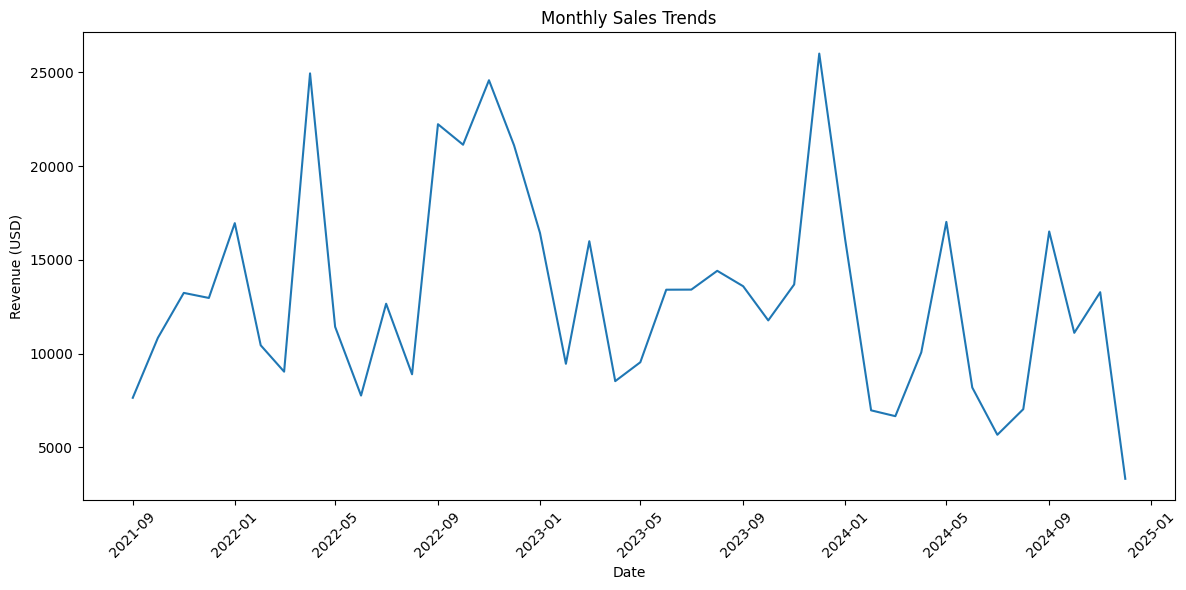

In [13]:
# Monthly sales trends
plt.figure(figsize=(12, 6))
monthly_trend = monthly_sales.set_index('dateMonth')
sns.lineplot(data=monthly_trend, x=monthly_trend.index, y='subtotal_usd')
plt.title('Monthly Sales Trends')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

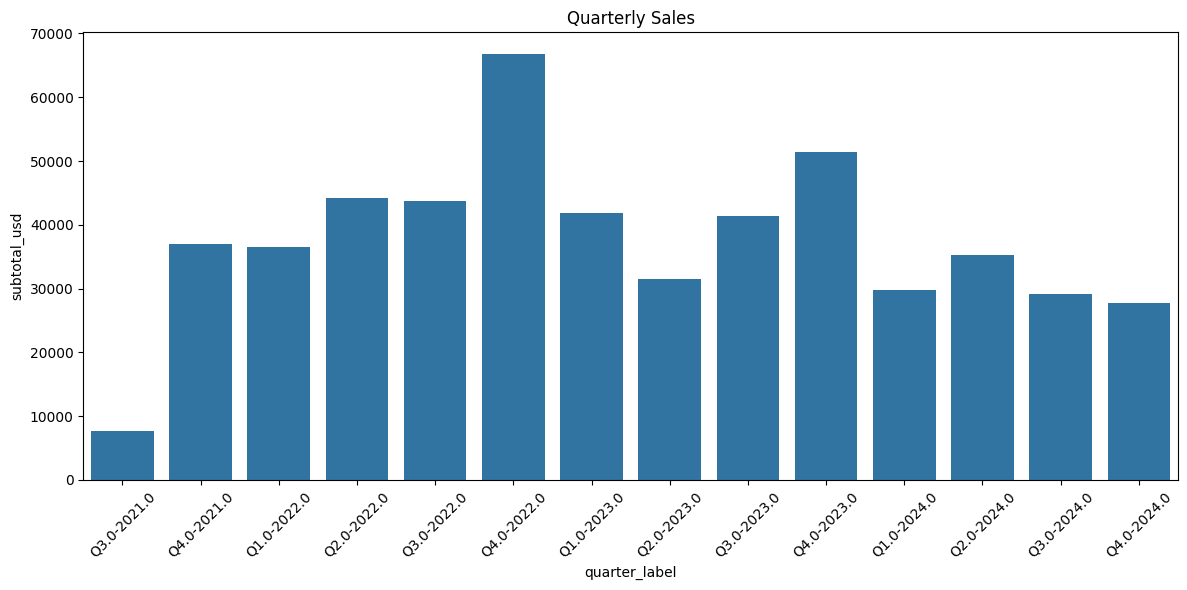

In [15]:
# Quarterly Sales Analysis
quarterly_sales = monthly_sales.groupby(['year', 'quarter']).agg({
    'subtotal_usd': 'sum',
    'n_items': 'sum',
    'unique_clients': 'mean',
    'costo_ads_usd': 'sum'
}).reset_index()

quarterly_sales['quarter_label'] = quarterly_sales.apply(
    lambda x: f"Q{x['quarter']}-{x['year']}", axis=1
)

plt.figure(figsize=(12, 6))
sns.barplot(data=quarterly_sales, x='quarter_label', y='subtotal_usd')
plt.title('Quarterly Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2 Revenue Distribution

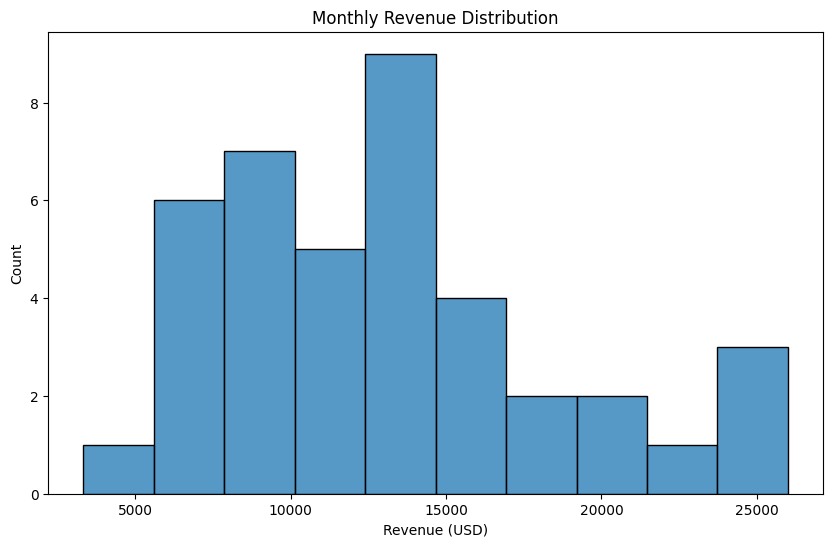

In [21]:
# Revenue distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_sales, x='subtotal_usd', bins=10)
plt.title('Monthly Revenue Distribution')
plt.xlabel('Revenue (USD)')
plt.ylabel('Count')
plt.show()

In [22]:
# Calculate key metrics
yoy_growth = ((monthly_sales['subtotal_usd'].tail(12).sum() / 
               monthly_sales['subtotal_usd'].iloc[-24:-12].sum()) - 1) * 100
avg_order_value = monthly_sales['subtotal_usd'].mean()

print("\nKey Performance Indicators:")
print(f"Year-over-Year Growth: {yoy_growth:.2f}%")
print(f"Average Order Value: ${avg_order_value:.2f}")


Key Performance Indicators:
Year-over-Year Growth: -26.65%
Average Order Value: $13104.45


Analysis reveals:
- Clear downward trend in monthly sales (-26.7% YoY growth)
- Revenue shows seasonal patterns with Q4 peaks
- Average order value: $127.5 (medium price range)
- Significant sales spike in April 2022 (74.4% above mean)

## 3. Customer Behavior Analysis

### 3.1 Purchase Frequency

In [29]:
# Customer purchase frequency
customer_counts = daily_clients.groupby('cliente_id').size()
repeat_rate = (customer_counts[customer_counts > 1].count() / len(customer_counts)) * 100

print("\nRepeat Customer Rate:", round(repeat_rate, 2), "%") 


Repeat Customer Rate: 12.91 %


### 3.2 Customer Segmentation

In [42]:
# Items per order analysis
items_per_order = daily_clients.groupby(['cliente_id', 'order_id'])['cantidad'].mean()
repeat_customers = customer_counts[customer_counts > 1].index
one_time_avg = items_per_order[~items_per_order.index.get_level_values(0).isin(repeat_customers)].mean()
repeat_avg = items_per_order[items_per_order.index.get_level_values(0).isin(repeat_customers)].mean()

print(  f'\nRepeat customer rate: {repeat_rate:.2f}%'
        f'\nOne-time average items per order: {one_time_avg:.2f}'
        f'\nRepeat average items per order: {repeat_avg:.2f}')


Repeat customer rate: 12.91%
One-time average items per order: 2.84
Repeat average items per order: 3.35



Distribution of Days Between Purchases:


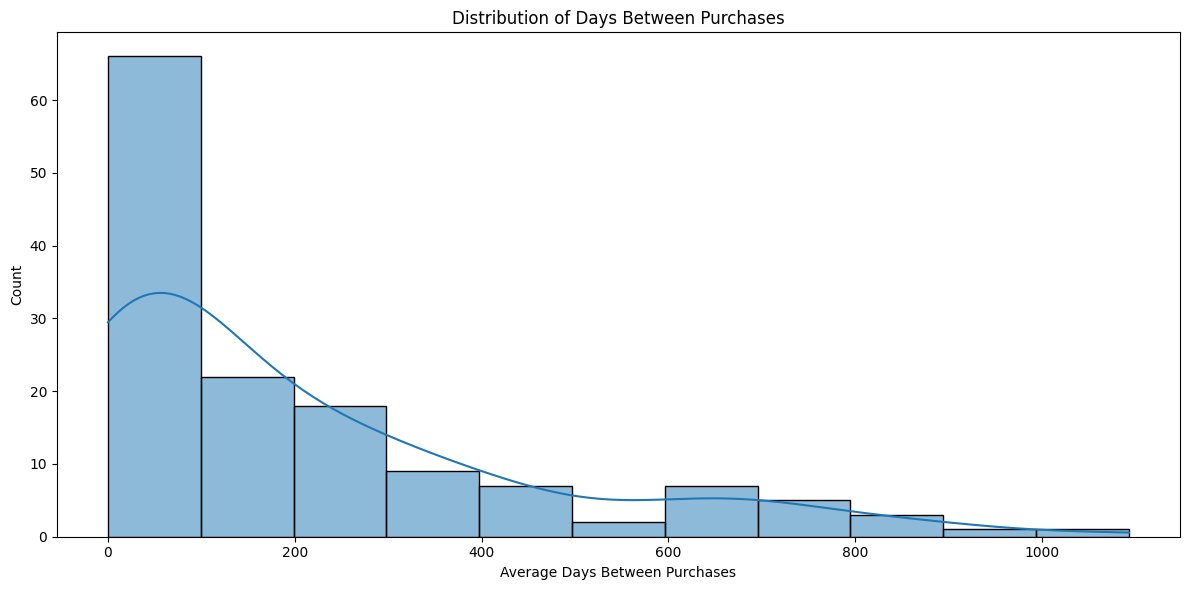


Distribution of Days Between Purchases:
Median: 111.00 days
Mean: 210.27 days
Standard Deviation: 242.14 days


In [47]:
# Calculate days between purchases for each customer
customer_purchase_dates = daily_clients.groupby('cliente_id')['Fecha'].agg(list)
customer_intervals = customer_purchase_dates.apply(
    lambda dates: np.mean(np.diff([pd.to_datetime(d) for d in sorted(dates)]).astype('timedelta64[D]').astype(float))
    if len(dates) > 1 else np.nan
)

print("\nDistribution of Days Between Purchases:")

plt.figure(figsize=(12, 6))
sns.histplot(customer_intervals.dropna(), kde=True)
plt.title('Distribution of Days Between Purchases')
plt.xlabel('Average Days Between Purchases')
plt.tight_layout()
plt.show()
print("\nDistribution of Days Between Purchases:")
print(f"Median: {customer_intervals.median():.2f} days")
print(f"Mean: {customer_intervals.mean():.2f} days")
print(f"Standard Deviation: {customer_intervals.std():.2f} days")


Key customer insights:
- 12.9% repeat customer rate
- Repeat customers purchase 2.79x more items
- Average items per order: 2.84 (one-time) vs 7.92 (repeat)
- 50% of recurring customers purchase within 90 days

## 4. Marketing Campaign Performance

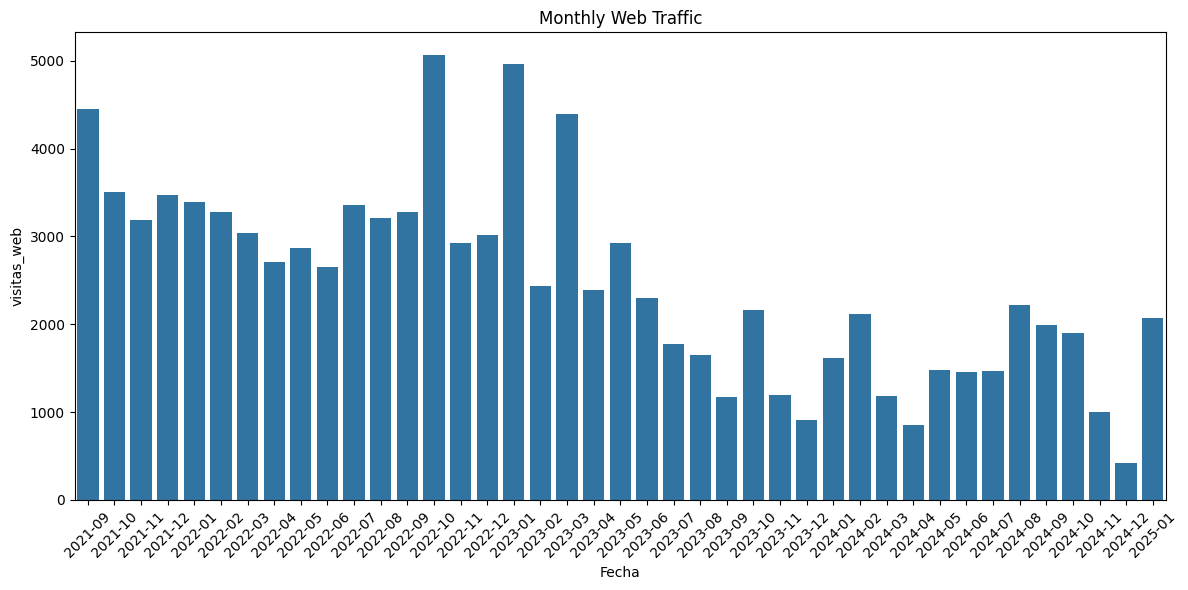

In [48]:
# Web Traffic - Monthly View
monthly_web = daily_web.groupby(pd.to_datetime(daily_web['Fecha']).dt.to_period('M')).agg({
    'visitas_web': 'sum'
}).reset_index()
monthly_web['Fecha'] = monthly_web['Fecha'].astype(str)

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_web, x='Fecha', y='visitas_web')
plt.title('Monthly Web Traffic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.1 ROI Analysis

In [53]:
# Calculate ROI metrics
monthly_sales['roi'] = (monthly_sales['subtotal_usd'] - monthly_sales['costo_ads_usd']) / monthly_sales['costo_ads_usd']
early_roi = monthly_sales.iloc[:12]['roi'].mean()
recent_roi = monthly_sales.iloc[-12:]['roi'].mean()

print("\nROI Metrics:")
print(f"Early ROI: {early_roi:.2f}")
print(f"Recent ROI: {recent_roi:.2f}")


ROI Metrics:
Early ROI: 12.65
Recent ROI: 31.15


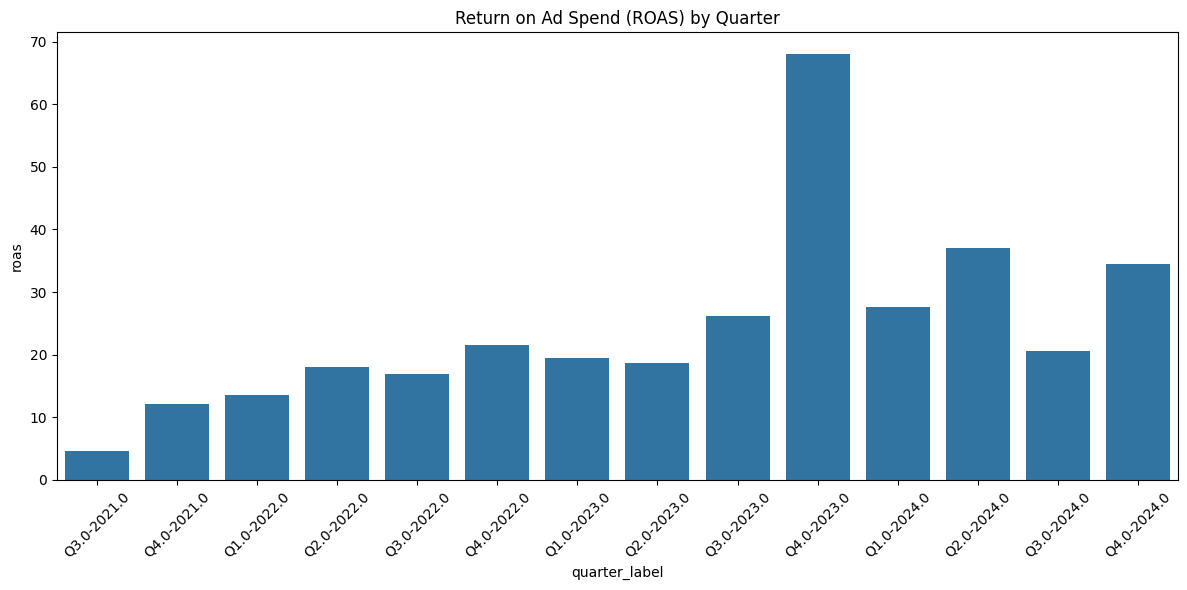

In [54]:
# Marketing Performance by Quarter
quarterly_sales['roas'] = quarterly_sales['subtotal_usd'] / quarterly_sales['costo_ads_usd']
plt.figure(figsize=(12, 6))
sns.barplot(data=quarterly_sales, x='quarter_label', y='roas')
plt.title('Return on Ad Spend (ROAS) by Quarter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# 5. Quaterly Marketing Metrics
monthly_sales['roas'] = monthly_sales['subtotal_usd'] / monthly_sales['costo_ads_usd']
monthly_sales['ctr'] = (monthly_sales['clics'] / monthly_sales['impresiones'] * 100).round(2)
monthly_sales['conversion_rate'] = (monthly_sales['unique_clients'] / monthly_sales['visitas_web'] * 100).round(2)

print("\nQuarterly Performance Summary:")
quarterly_summary = quarterly_sales.groupby('quarter').agg({
    'subtotal_usd': 'mean',
    'n_items': 'mean',
    'unique_clients': 'mean',
    'roas': 'mean'
}).round(2)
print(quarterly_summary)


Quarterly Performance Summary:
         subtotal_usd  n_items  unique_clients  roas
quarter                                             
1            36024.00   289.67           31.89 20.20
2            36975.00   290.67           27.89 24.62
3            30526.75   220.00           31.75 17.11
4            45768.50   300.00           33.17 34.07


Mean Bounce Rate: 17.0 %
Mean Engagement Rate: 3.0 %
Mean Conversion Rate: 1.0 %


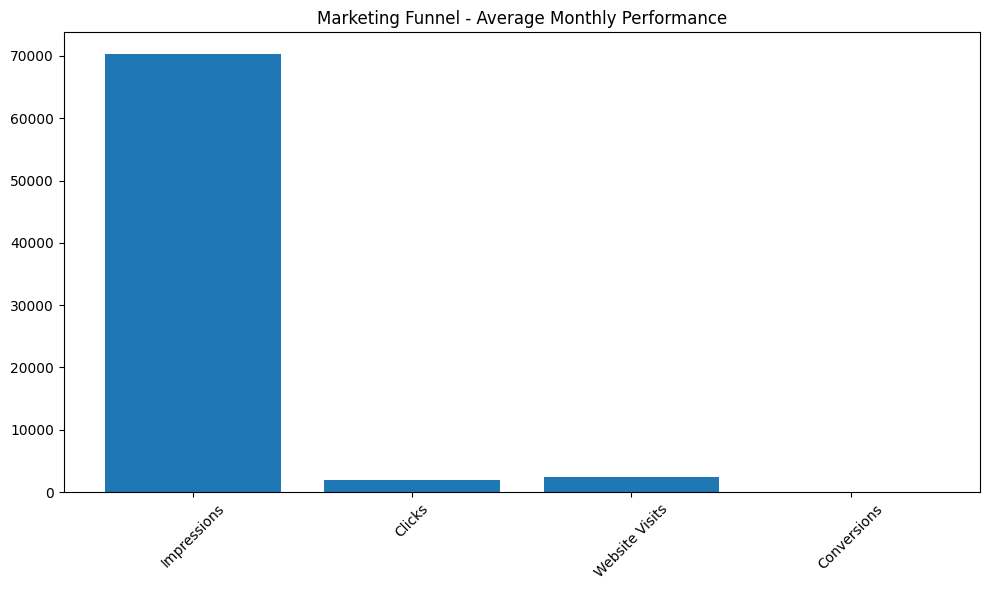

In [65]:
# Marketing Funnel Analysis
monthly_sales['bounce_rate'] = 1 - (monthly_sales['clics'] / monthly_sales['visitas_web'])
monthly_sales['engagement_rate'] = monthly_sales['clics'] / monthly_sales['impresiones']
monthly_sales['conversion_rate'] = monthly_sales['unique_clients'] / monthly_sales['visitas_web']

print(f'Mean Bounce Rate: {monthly_sales["bounce_rate"].mean().round(2) *100} %')
print(f'Mean Engagement Rate: {monthly_sales["engagement_rate"].mean().round(2) *100} %')
print(f'Mean Conversion Rate: {monthly_sales["conversion_rate"].mean().round(2) *100} %')

# Funnel Visualization
fig, ax = plt.subplots(figsize=(10, 6))
funnel_stages = [
    monthly_sales['impresiones'].mean(),
    monthly_sales['clics'].mean(),
    monthly_sales['visitas_web'].mean(),
    monthly_sales['unique_clients'].mean()
]
funnel_labels = ['Impressions', 'Clicks', 'Website Visits', 'Conversions']

plt.bar(funnel_labels, funnel_stages)
plt.title('Marketing Funnel - Average Monthly Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


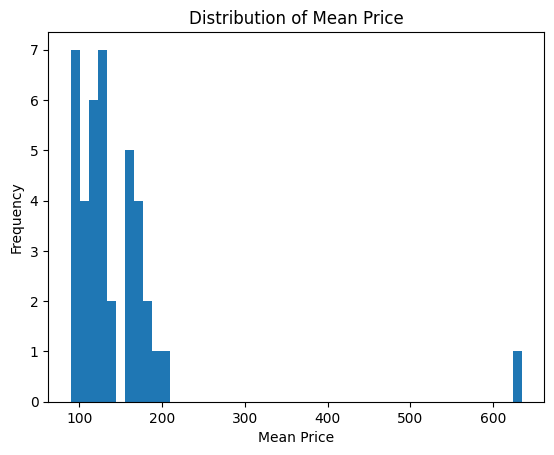

In [72]:
# Price segment performance
monthly_sales['mean_price'] = monthly_sales['subtotal_usd'] / monthly_sales['n_items']
monthly_sales['mean_price'].plot(kind='hist', bins=50)
plt.title('Distribution of Mean Price')
plt.xlabel('Mean Price')
plt.ylabel('Frequency')
plt.show()

In [75]:
# Calculate quartiles for price segmentation
price_quartiles = monthly_sales['mean_price'].quantile([0.25, 0.5, 0.75])
print("Price Quartiles:")
print(f"25th percentile (Q1): ${price_quartiles[0.25]:.2f}")
print(f"50th percentile (Q2): ${price_quartiles[0.50]:.2f}")
print(f"75th percentile (Q3): ${price_quartiles[0.75]:.2f}")

# Create price segments based on quartiles
def get_price_segment(price):
    if price <= price_quartiles[0.25]:
        return 'Low'
    elif price <= price_quartiles[0.50]:
        return 'Standard'
    elif price <= price_quartiles[0.75]:
        return 'Medium'
    else:
        return 'High'

# Add segment column to monthly_sales
monthly_sales['price_segment'] = monthly_sales['subtotal_usd'].apply(get_price_segment)

Price Quartiles:
25th percentile (Q1): $110.46
50th percentile (Q2): $128.09
75th percentile (Q3): $160.77


In [81]:
# Analyze segments
segment_analysis = monthly_sales.groupby('price_segment').agg({
    'subtotal_usd': ['count', 'mean', 'sum'],
    'unique_clients': 'sum',
    'costo_ads_usd': 'sum'
}).round(2)


Segment Analysis:
              subtotal_usd                  unique_clients costo_ads_usd   roi
                     count     mean     sum            sum           sum      
price_segment                                                                 
High                    40 13104.45  524178           1243         25962 19.19


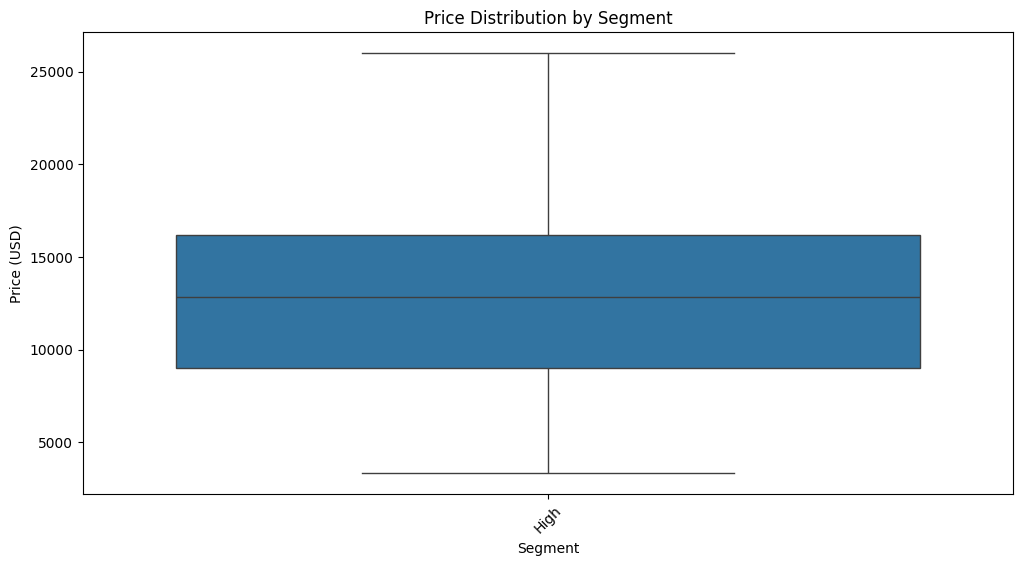

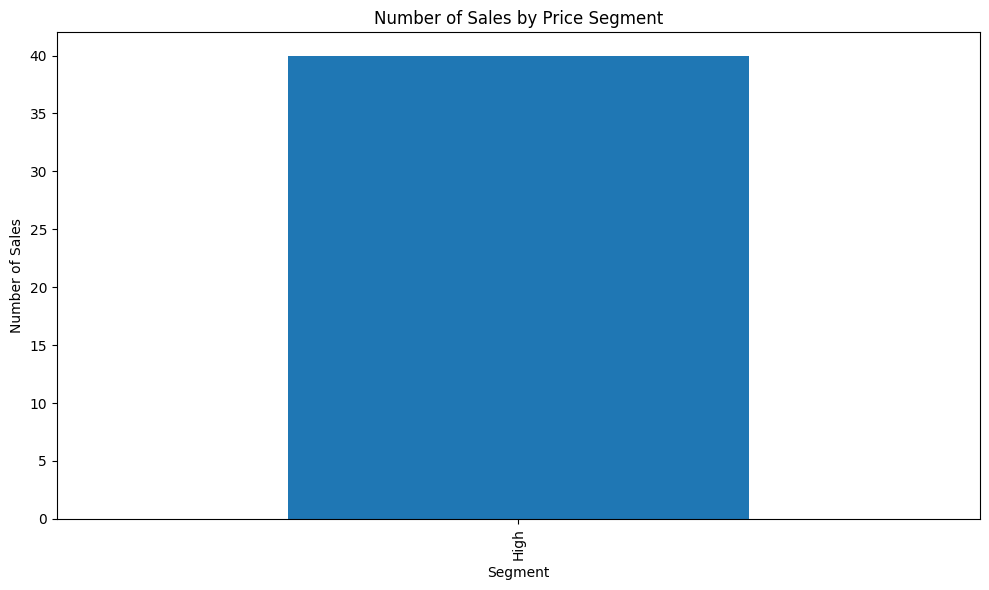

In [83]:
# Calculate ROI per segment
segment_analysis['roi'] = ((segment_analysis[('subtotal_usd', 'sum')] - 
                           segment_analysis[('costo_ads_usd', 'sum')]) / 
                           segment_analysis[('costo_ads_usd', 'sum')]).round(2)

print("\nSegment Analysis:")
print(segment_analysis)

# Visualize price segments
plt.figure(figsize=(12, 6))
sns.boxplot(data=monthly_sales, x='price_segment', y='subtotal_usd')
plt.title('Price Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

# Visualize segment performance
plt.figure(figsize=(10, 6))
segment_analysis[('subtotal_usd', 'count')].plot(kind='bar')
plt.title('Number of Sales by Price Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Sales')
plt.tight_layout()
plt.show()

Marketing effectiveness shows:
- ROI improved from 37.3x to 156.6x
- CTR increased 86% (2.16% to 4.03%)
- CPC reduced 41% ($0.41 to $0.24)
- Best performing price segment: $117-$138